# EDA Exercise 1 - Salary Insights 
## This is a data cleaning and preprocessing exercise conducted on a real world survey data on salary dataset sourced from https://www.r-bloggers.com/2021/04/a-real-world-messy-dataset-to-practice-on/. The data is a Salary Survey from AskAManager.org. EDA is also conducted on the dataset

### Step 1: understanding dataset properties and cleaning / replacing data ( for nan values where necessary)

In [1]:
# import working environment 
import pandas as pd 
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt
import sklearn
import datetime
import pandas.testing as tm


D:\Downloaded programs\Anaconda\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# import dataset 
salary_df=pd.read_csv('D:\Data Sci\EDA\salary insight form.csv')


In [3]:
# understand dataset properties
salary_df.head()
salary_df.dtypes

Timestamp                                    object
How old are you?                             object
Industry                                     object
Job title                                    object
Additional context on job title              object
Annual salary                                object
Other monetary comp                         float64
Currency                                     object
Currency - other                             object
Additional context on income                 object
Country                                      object
State                                        object
City                                         object
Overall years of professional experience     object
Years of experience in field                 object
Highest level of education completed         object
Gender                                       object
Race                                         object
dtype: object

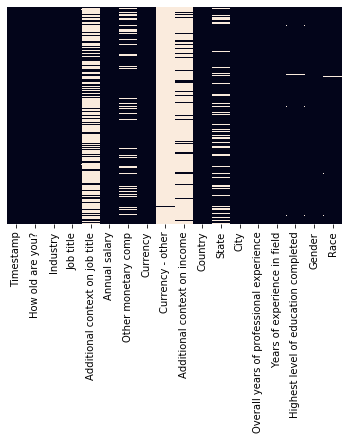

In [4]:
# find out nan values in dataset
sns.heatmap(salary_df.isnull(),yticklabels=False, cbar=False)

In [5]:
# drop these 3 columns with very high nan values
salary_df=salary_df.drop(['Currency - other','Additional context on job title','Additional context on income'],axis=1)
# drop rows of columns with minimal nan values 
salary_df=salary_df.dropna(subset=['Gender','Industry'])

In [6]:
# fill na in other monetary comp with 0
salary_df.fillna({'Other monetary comp':0},inplace=True)


In [7]:
# 'Other monetary comp' column to switch type from float64 to object. 
salary_df['Annual salary']=salary_df['Annual salary'].str.replace(',',"").astype(int)
print(salary_df['Annual salary'])
salary_df['Other monetary comp']=salary_df['Other monetary comp'].astype(int)

0         55000
1         54600
2         34000
3         62000
4         60000
          ...  
27720    225000
27721     59500
27722     78750
27723     78750
27724     64000
Name: Annual salary, Length: 27492, dtype: int32


In [8]:
# add annual salary and other monetary comp together 
salary_df['Total annual salary'] = salary_df.apply(lambda x: x['Annual salary']+x['Other monetary comp'],axis=1).astype(int)

# drop annual salary and other monetary comp columns
salary_df=salary_df.drop(columns=['Annual salary','Other monetary comp'])
# drop all duplicates in dataset
salary_df=salary_df.drop_duplicates()

In [9]:
# clean the country column
from dataprep.clean import clean_country

salary_df=clean_country(salary_df, 'Country', fuzzy_dist=2, output_format='alpha-2',inplace=True)

  0%|          | 0/9 [00:00<?, ?it/s]

Country Cleaning Report:
	24930 values cleaned (90.68%)
	1 values unable to be parsed (0.0%), set to NaN
Result contains 27491 (100.0%) values in the correct format and 1 null values (0.0%)


In [10]:
# rename column for cleaned data on country
salary_df=salary_df.rename(columns={'Country_clean':'Country'})

In [11]:
# drop nan row in country cleaned data
nan_index=salary_df[salary_df['Country'].isnull()].index
salary_df=salary_df.drop(nan_index)

In [12]:
# drop missing data in race and highest level of education completed
salary_df=salary_df.dropna(axis=0,how='any',subset=['Race','Highest level of education completed'])

In [13]:
# get date output 
salary_df['Timestamp']=pd.to_datetime(salary_df['Timestamp'],dayfirst=True)
salary_df['Date']=salary_df['Timestamp'].dt.date
salary_df['Time']=salary_df['Timestamp'].dt.time

### Step 1a: filtering outliers

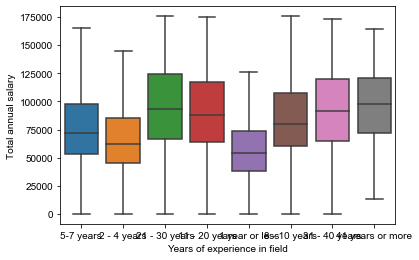

In [14]:
# filtering outliers from salary plot 
quantile1=np.quantile(salary_df['Total annual salary'],0.25)
quantile3=np.quantile(salary_df['Total annual salary'],0.75)
IQR=quantile3-quantile1
outlier_df=salary_df[(salary_df['Total annual salary']>quantile3+IQR)&(salary_df['Total annual salary']<quantile1-IQR)]
salary_df_filtered=salary_df[(salary_df['Total annual salary']<quantile3+IQR)&(salary_df['Total annual salary']>quantile1-IQR)]
# look at distributions and anomaly
sns.boxplot(x=salary_df_filtered['Years of experience in field'],y=salary_df_filtered['Total annual salary'],data=salary_df_filtered,showfliers=False)
sns.set(rc = {'figure.figsize':(8,25)})

### Step 2: undertake one hot encoding and label encoding on categorical columns 

In [15]:
# label encoding and/or one hot encoding on categorical columns 
dict_map={'1 year or less' : int(0),'2 - 4 years' : int(1),'5-7 years' : int(2),'8 - 10 years' : int(3), '11-20 years' : int(4),'21 - 30 years' : int(5),'31 - 40 years' : int(6),'41 years or more' : int(7)} 
salary_df_filtered['Overall years of professional experience']=salary_df_filtered['Overall years of professional experience'].map(dict_map)
salary_df_filtered['Years of experience in field']=salary_df_filtered['Years of experience in field'].map(dict_map)


D:\Downloaded programs\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Downloaded programs\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [16]:
print(salary_df_filtered['Gender'].unique().tolist())

['Woman', 'Non-binary', 'Man', 'Other or prefer not to answer', 'Prefer not to answer']


In [17]:
# perform one hot encoding to gender 
salary_df_filtered['Gender']=salary_df_filtered['Gender'].replace('Other or prefer not to answer', 'Others')
salary_df_filtered['Gender']=salary_df_filtered['Gender'].replace('Prefer not to answer', 'Others')

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)

data_gender = pd.DataFrame(ohe.fit_transform(salary_df_filtered[["Gender"]]))
data_gender.columns=ohe.get_feature_names(["Gender"])

salary_df_filtered=pd.concat([salary_df_filtered,data_gender], axis=1)
from warnings import filterwarnings
filterwarnings(action='ignore', category=DeprecationWarning, message='`np.bool` is a deprecated alias')
filterwarnings(action='ignore', category=DeprecationWarning, message='`np.int` is a deprecated alias for the builtin `int`')


D:\Downloaded programs\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Downloaded programs\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Downloaded programs\Anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:395: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, 

## Step 3: Visualize relationships of Numerical Features 

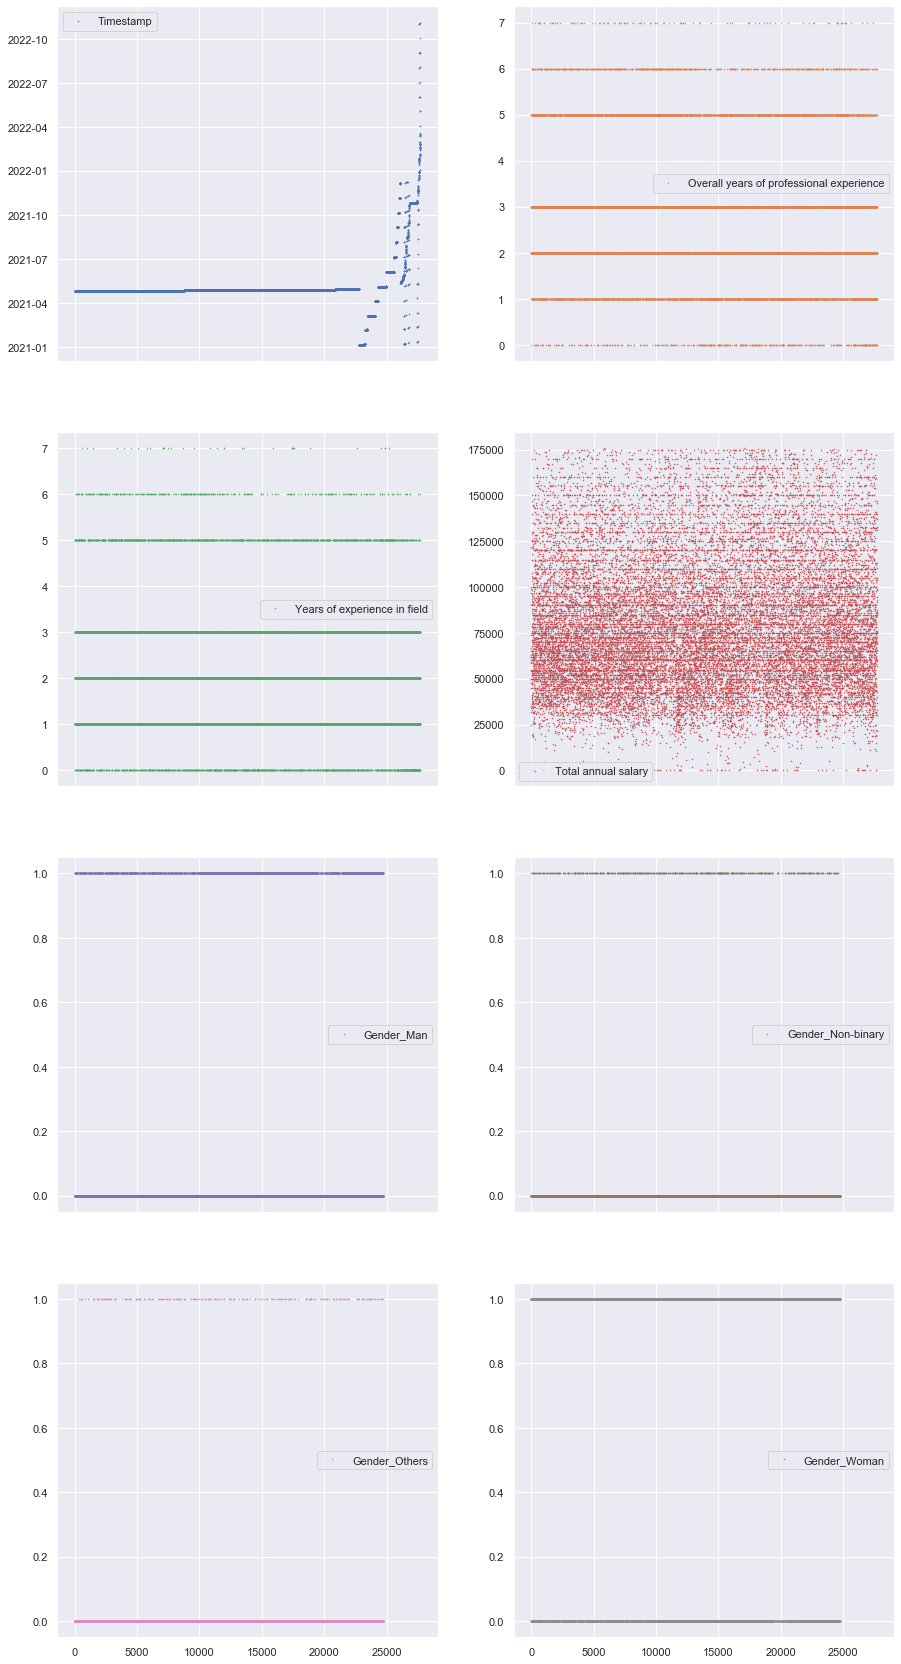

In [18]:
# final sense check on numerical features
salary_df_filtered.plot(lw=0,
          marker=".",
          subplots=True,
          layout=(-1, 2),
          figsize=(15, 30),
          markersize=1);

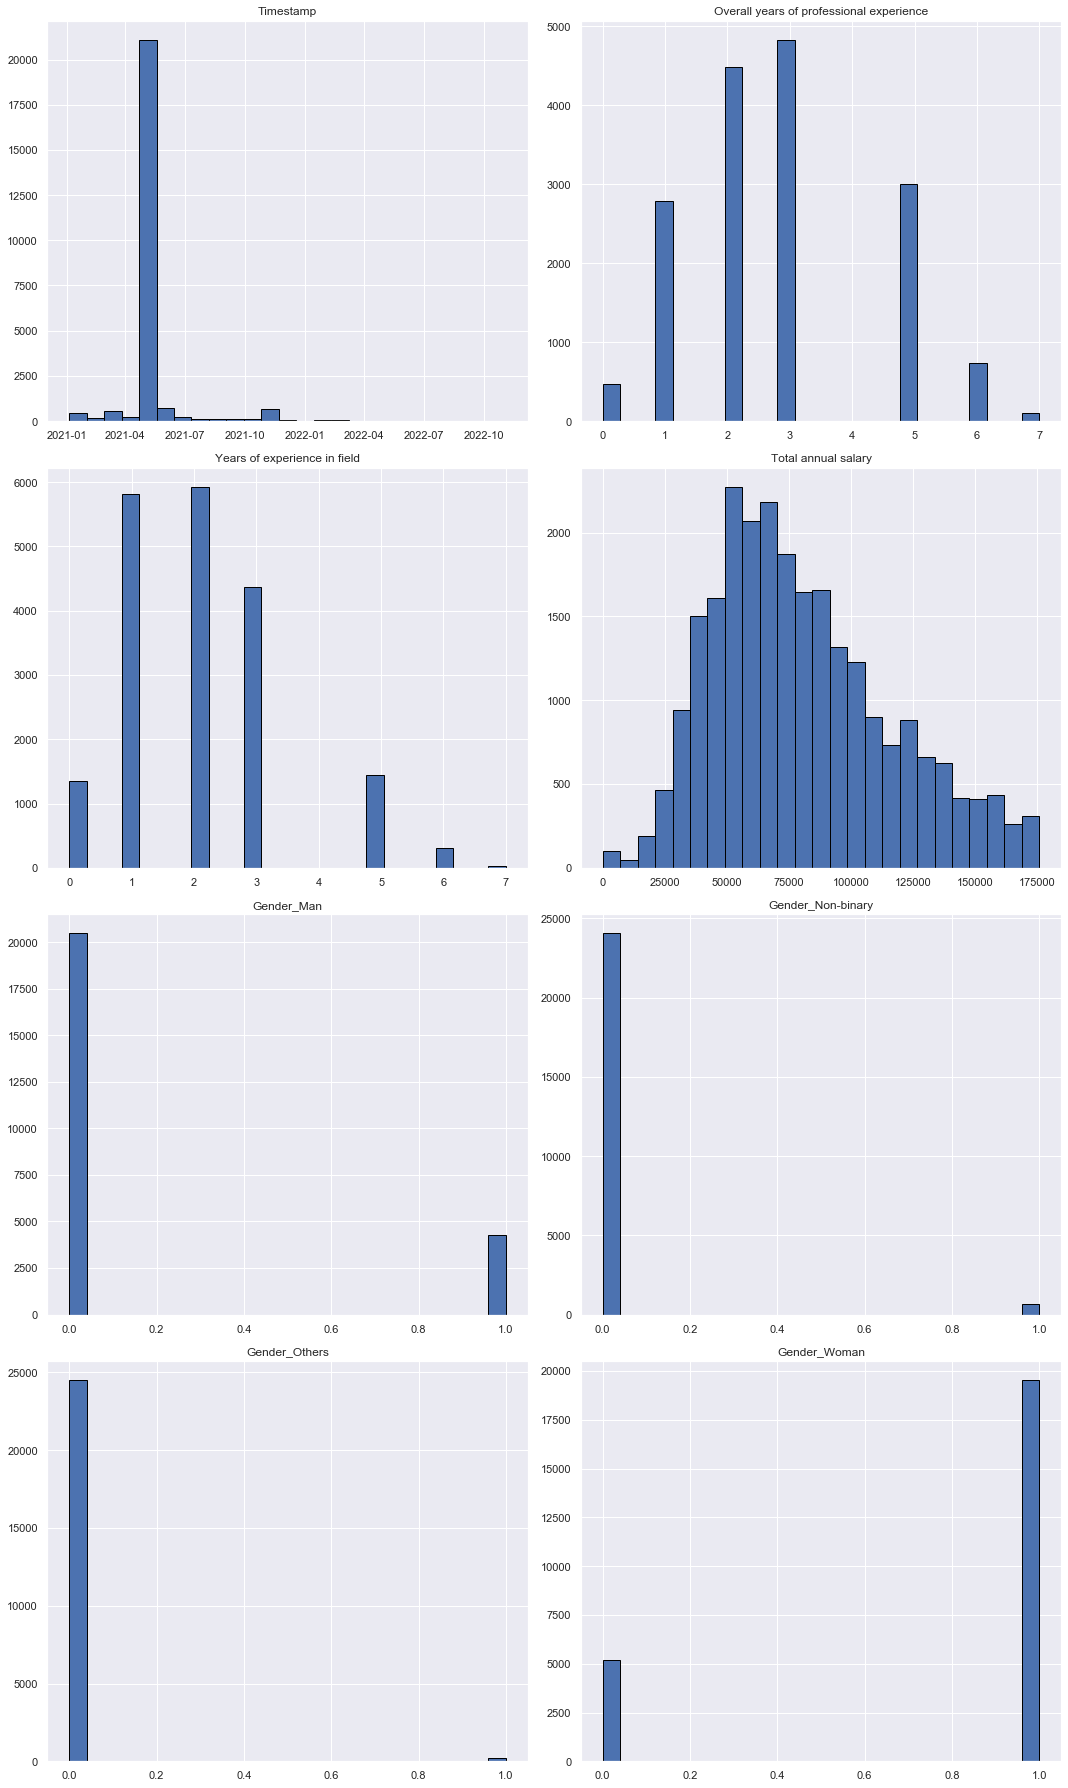

In [19]:
# Plots the histogram for each numerical feature in a separate subplot
salary_df_filtered.hist(bins=25, figsize=(15, 25), layout=(-1, 2), edgecolor="black")
plt.tight_layout();

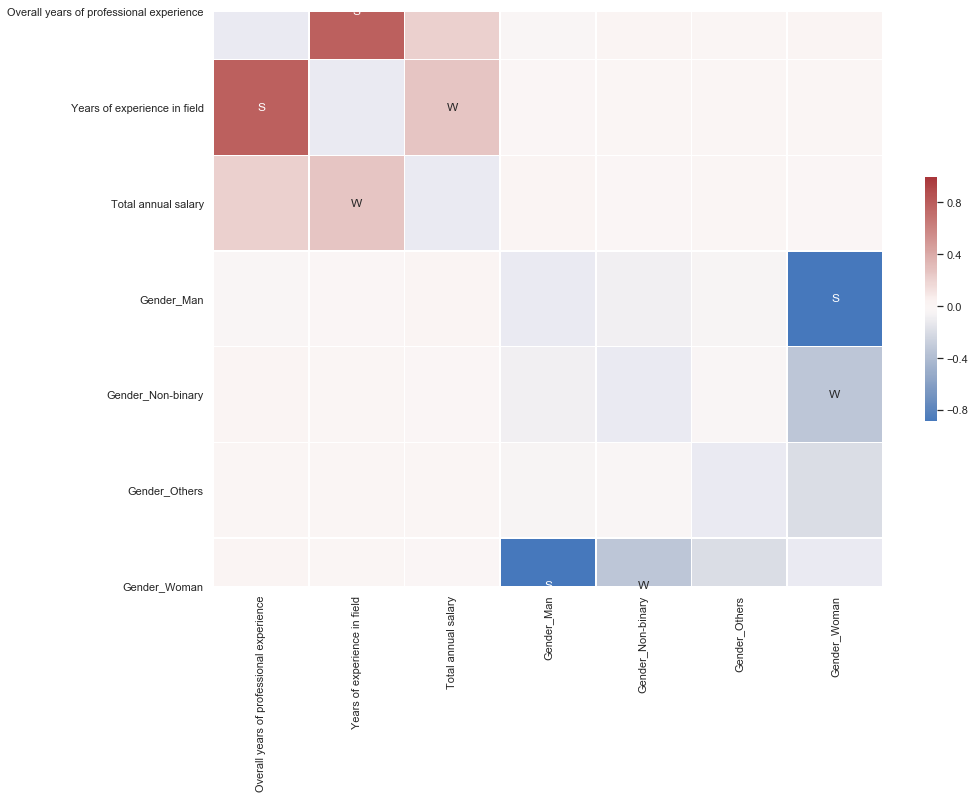

In [22]:
# Computes feature correlation
df_corr = salary_df_filtered.corr(method="pearson")

# Create labels for the correlation matrix
labels = np.where(np.abs(df_corr)>0.75, "S",
                  np.where(np.abs(df_corr)>0.5, "M",
                           np.where(np.abs(df_corr)>0.25, "W", "")))

# Plot correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.3});


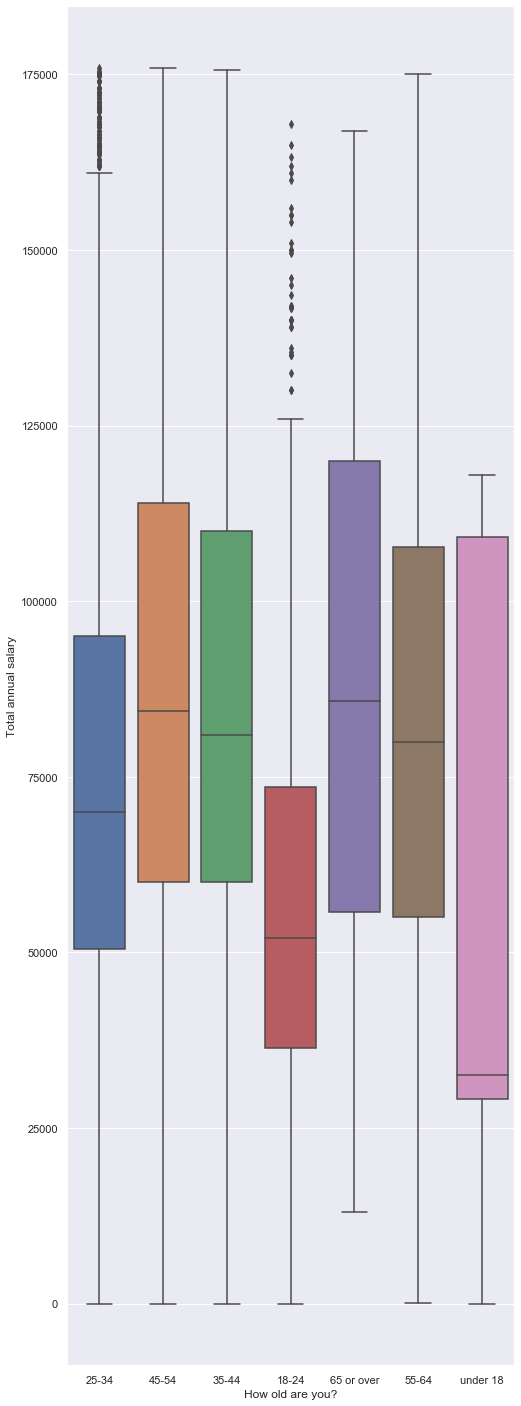

In [23]:
# investigate non-numerical features using boxplot/violinplot
sns.boxplot(x='How old are you?',y='Total annual salary',data=salary_df_filtered)
sns.set(rc = {'figure.figsize':(8,25)})

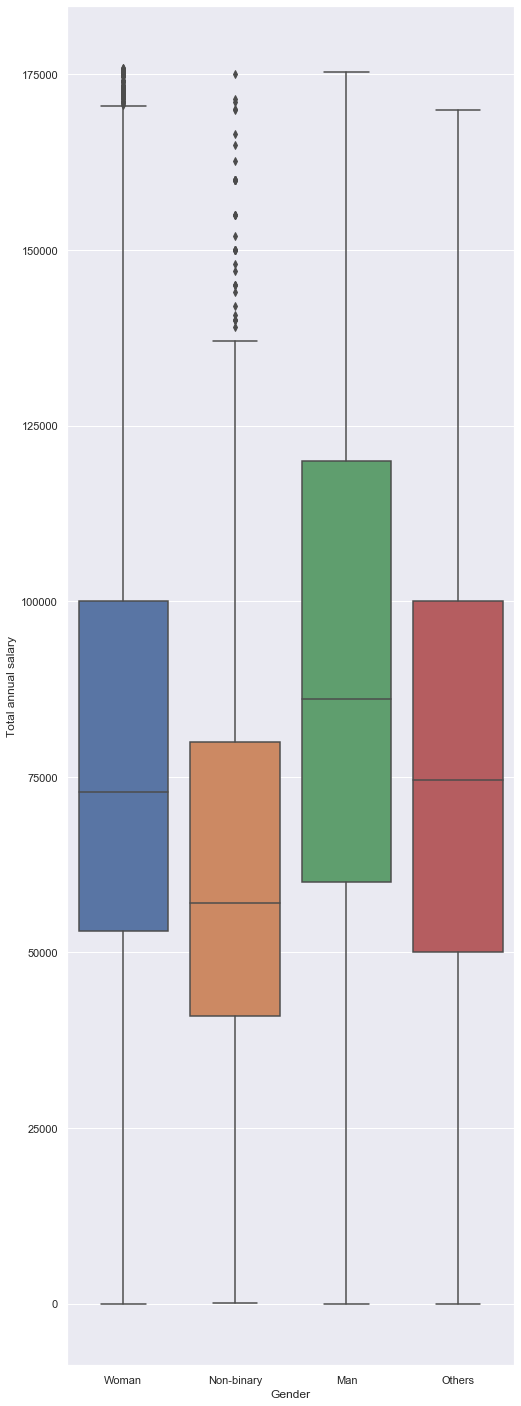

In [27]:
sns.boxplot(x='Gender',y='Total annual salary',data=salary_df_filtered)
sns.set(rc = {'figure.figsize':(8,25)})

### insights from data visualisation done above. 
1. There is a strong correlation between years of experience in field and salary
2. There is no strong correlation between gender and salary. 
3. There is still a slight bias for man's salary levels vs woman's. Non-binary people salary's are much lower compared to man/woman salary. 



### things to work on further
1. Build a dashboard so that other people can find out their expected salary range for their industry/job based on their personal factors and experience 